# `ilastikrag` Tutorial: Anisotropic Data

In [1]:
%matplotlib inline
import matplotlib
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 20.0)
from ilastikrag.util import colorize_labels
from collections import OrderedDict
from itertools import groupby
from IPython.display import display

In [2]:
import numpy as np
import pandas as pd
import vigra
import ilastikrag

## Load Data

In [3]:
# Note: Rag inputs must be VigraArray (with axistags)
grayscale_2d =   vigra.impex.readImage('grayscale.png', dtype='NATIVE').withAxes('yx')
membranes_2d =   vigra.impex.readImage('membranes.png', dtype='NATIVE').withAxes('yx')
superpixels_2d = vigra.impex.readImage('superpixels.png', dtype=np.uint32).withAxes('yx')

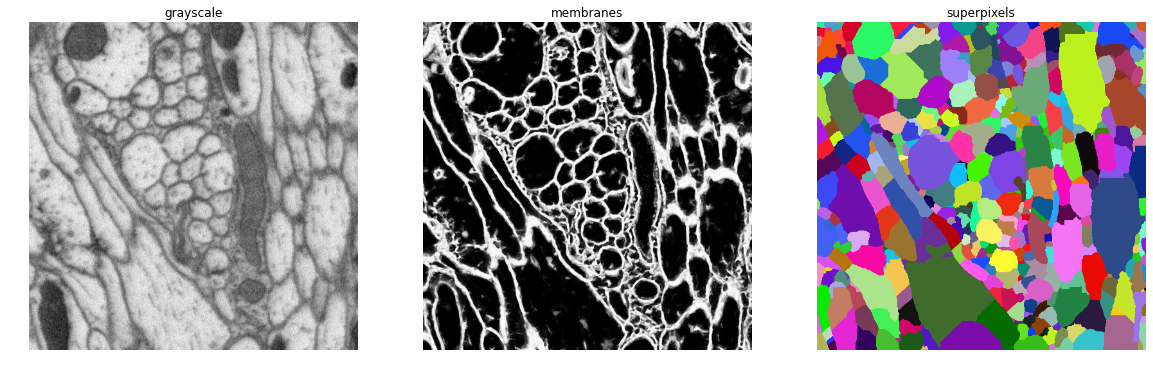

In [4]:
vigra.multiImshow(OrderedDict( [('grayscale',   (grayscale_2d, 'img')),
                                ('membranes',   (membranes_2d, 'img')),
                                ('superpixels', (colorize_labels(superpixels_2d), 'img'))]), (1,3))

### (Fabricate 3D data)

In [5]:
# Just for this tutorial, we're cheating:
# We'll just stack copies of the 2D data
grayscale = np.tile(grayscale_2d, (20,1,1))
grayscale.axistags = vigra.defaultAxistags('zyx')

membranes = np.tile(membranes_2d, (20,1,1))
membranes.axistags = vigra.defaultAxistags('zyx')

superpixels = np.zeros(shape=grayscale.shape, dtype=np.uint32)
superpixels = vigra.taggedView(superpixels, 'zyx')

# Every slice must have unique ids
for z in range(superpixels.shape[0]):
    superpixels[z] = superpixels_2d + superpixels_2d.max()+1


## Create Rag: `flat_superpixels=True`

In [6]:
rag = ilastikrag.Rag(superpixels, flat_superpixels=True)

## Compute features along isotropic axes (`edge_group='yx'`)

In [7]:
iso_edge_features = rag.compute_features( grayscale,
                                          ['standard_edge_mean', 'standard_sp_quantiles_50'],
                                          edge_group='yx' )
iso_edge_features[:5]

,sp1,sp2,standard_edge_mean,standard_sp_quantiles_50_sum,standard_sp_quantiles_50_difference
0,8021,8022,132.987503,281.609375,3.281250
1,8021,8026,131.001465,280.913116,2.584991
2,8021,8398,133.219238,280.093445,1.765320
3,8022,8026,134.985001,284.194366,0.696259
4,8022,8308,137.365005,281.956177,2.934433


## Compute 'flatedge' features along the anisotropic axis (`edge_group='z'`)

In [8]:
aniso_edge_features = rag.compute_features( grayscale,
                                          ['standard_flatedge_mean', 'standard_flatedge_quantiles_50'],
                                          edge_group='z' )
aniso_edge_features[:5]

,sp1,sp2,standard_flatedge_mean,standard_flatedge_quantiles_50
0,8021,8021,132.896103,133.665375
1,8022,8022,133.906738,134.682404
2,8026,8026,134.535034,136.850037
3,8029,8029,133.336945,133.791199
4,8049,8049,132.460648,133.865921


## Optional: Join features into one table

In [9]:
all_edge_features = pd.concat((iso_edge_features, aniso_edge_features))

# If tables don't have the same column names, you'll see NaNs.
# Depending on your intentions, you may want to rename the 
# columns before calling pd.concat(), or call DataFrame.fillna() on the result.
display(all_edge_features[:5])
display(all_edge_features[-5:])

,sp1,sp2,standard_edge_mean,standard_flatedge_mean,standard_flatedge_quantiles_50,standard_sp_quantiles_50_difference,standard_sp_quantiles_50_sum
0,8021,8022,132.987503,NaN,NaN,3.281250,281.609375
1,8021,8026,131.001465,NaN,NaN,2.584991,280.913116
2,8021,8398,133.219238,NaN,NaN,1.765320,280.093445
3,8022,8026,134.985001,NaN,NaN,0.696259,284.194366
4,8022,8308,137.365005,NaN,NaN,2.934433,281.956177


,sp1,sp2,standard_edge_mean,standard_flatedge_mean,standard_flatedge_quantiles_50,standard_sp_quantiles_50_difference,standard_sp_quantiles_50_sum
370,15965,15965,NaN,135.120087,135.504593,NaN,NaN
371,15985,15985,NaN,131.761276,135.079865,NaN,NaN
372,16012,16012,NaN,134.388916,135.268387,NaN,NaN
373,16026,16026,NaN,133.302338,134.518616,NaN,NaN
374,16039,16039,NaN,133.575897,135.278336,NaN,NaN


## Show supported feature names

In [10]:
for _, grouped_names in groupby(rag.supported_features(), lambda s: s.split('_')[:-1]):
    for feature_name in grouped_names:
        print feature_name
    print ""

standard_sp_count
standard_sp_sum
standard_sp_minimum
standard_sp_maximum
standard_sp_mean
standard_sp_variance
standard_sp_kurtosis
standard_sp_skewness
standard_sp_quantiles

standard_sp_quantiles_0
standard_sp_quantiles_10
standard_sp_quantiles_25
standard_sp_quantiles_50
standard_sp_quantiles_75
standard_sp_quantiles_90
standard_sp_quantiles_100

standard_sp_regionradii

standard_sp_regionradii_0
standard_sp_regionradii_1
standard_sp_regionradii_2

standard_sp_regionaxes

standard_sp_regionaxes_0x
standard_sp_regionaxes_0y
standard_sp_regionaxes_0z
standard_sp_regionaxes_1x
standard_sp_regionaxes_1y
standard_sp_regionaxes_1z
standard_sp_regionaxes_2x
standard_sp_regionaxes_2y
standard_sp_regionaxes_2z

standard_edge_count
standard_edge_sum
standard_edge_minimum
standard_edge_maximum
standard_edge_mean
standard_edge_variance
standard_edge_kurtosis
standard_edge_skewness
standard_edge_quantiles

standard_edge_quantiles_0
standard_edge_quantiles_10
standard_edge_quantiles_25
standard_